### Loading the cancer dataset into the R kernel

In [612]:
library(e1071)
library(rlist)
library(plyr)
library(dplyr)
library(naniar)
highskew_threshold=1
cancer = read.csv(file="/Users/axpatel/Downloads/cancer.csv", header=TRUE, sep=",")

### Summarizing the given dataset.

In [613]:
paste("The dataset contains the following parameters: ", paste(names(cancer), collapse=", "))
paste("The number of data points are: ", paste(nrow(cancer)))
str(cancer)
print(summary(cancer))

[1] "The dataset contains the following parameters:  X, avgAnnCount, medIncome, popEst2015, povertyPercent, binnedInc, MedianAge, MedianAgeMale, MedianAgeFemale, Geography, AvgHouseholdSize, PercentMarried, PctNoHS18_24, PctHS18_24, PctSomeCol18_24, PctBachDeg18_24, PctHS25_Over, PctBachDeg25_Over, PctEmployed16_Over, PctUnemployed16_Over, PctPrivateCoverage, PctEmpPrivCoverage, PctPublicCoverage, PctWhite, PctBlack, PctAsian, PctOtherRace, PctMarriedHouseholds, BirthRate, deathRate"

[1] "The number of data points are:  3047"

'data.frame':	3047 obs. of  30 variables:
 $ X                   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ avgAnnCount         : num  1397 173 102 427 57 ...
 $ medIncome           : int  61898 48127 49348 44243 49955 52313 37782 40189 42579 60397 ...
 $ popEst2015          : int  260131 43269 21026 75882 10321 61023 41516 20848 13088 843954 ...
 $ povertyPercent      : num  11.2 18.6 14.6 17.1 12.5 15.6 23.2 17.8 22.3 13.1 ...
 $ binnedInc           : Factor w/ 10 levels "(34218.1, 37413.8]",..: 9 6 6 4 6 7 2 2 3 8 ...
 $ MedianAge           : num  39.3 33 45 42.8 48.3 45.4 42.6 51.7 49.3 35.8 ...
 $ MedianAgeMale       : num  36.9 32.2 44 42.2 47.8 43.5 42.2 50.8 48.4 34.7 ...
 $ MedianAgeFemale     : num  41.7 33.7 45.8 43.4 48.9 48 43.5 52.5 49.8 37 ...
 $ Geography           : Factor w/ 3047 levels "Abbeville County, South Carolina",..: 1459 1460 1464 1589 1618 1766 2051 2112 2143 2185 ...
 $ AvgHouseholdSize    : num  2.54 2.34 2.62 2.52 2.34 2.58 2.42 2.24 2.38 2.65 ...
 $ PercentMarri

Based on the descriptive statistics, few of the fileds have highly skewed data and a couple of fields are missing values. Next, let's find the fields with high skew values and missing parameters. 

In [614]:
## Applying Pearson's moment coefficient to measyre the skewness (Ref: https://en.wikipedia.org/wiki/Skewness).
field_na = list()
field_skew = list()
high_skew = list()
for (col in names(cancer)){
    if(class(cancer[,col]) == "numeric"){
        skew = skewness(cancer[,col], na.rm=TRUE)
        x = c(col, skew)
        names(x) = c("field", "skew")
        field_skew = list.append(field_skew, x)
        if(skew >=highskew_threshold | skew<=(-1 * highskew_threshold)){
            high_skew = list.append(high_skew, x)
        }
    }
    if(any(is.na(cancer[,col]))){
        y = c(col, sum(is.na(cancer[,col]))/nrow(cancer))
        names(y) = c('field', '%_na')
        field_na = list.append(field_na, y)
    }
}
paste("Parameters with high skew values", paste(high_skew, collapse=", "))
paste("Parameters with missing values", paste(field_na, collapse=", "))

[1] "Parameters with high skew values c(field = \"avgAnnCount\", skew = \"10.6699469231418\"), c(field = \"MedianAge\", skew = \"9.98011048305904\"), c(field = \"AvgHouseholdSize\", skew = \"-3.37765974286406\"), c(field = \"PctBachDeg18_24\", skew = \"1.95427511250128\"), c(field = \"PctBachDeg25_Over\", skew = \"1.09375937288389\"), c(field = \"PctWhite\", skew = \"-1.67924959621828\"), c(field = \"PctBlack\", skew = \"2.25584567660411\"), c(field = \"PctAsian\", skew = \"7.41073850927254\"), c(field = \"PctOtherRace\", skew = \"4.94730473909713\"), c(field = \"BirthRate\", skew = \"1.3219002880993\")"

[1] "Parameters with missing values c(field = \"PctSomeCol18_24\", `%_na` = \"0.749917952084017\"), c(field = \"PctEmployed16_Over\", `%_na` = \"0.0498851329176239\")"

Any field with Pearson's coefficient larger/smaller than a threshold (highskew_threshold=3) is classified as a field with considerable right/left-skewed distribution. The potential causes may be (1) the existance of anomalies or (2) errornous data reporting. One approach to understand the distribution is to visualize data distribitions.

## Analyzing missing values

* The PctSomeCol18_24 field has 74\% of data missing, which can heavily influence the univariate and multivariate data analysis. Thus, we excluded the analysis of PctSomeCol18_24 from this study.
* On the other hand, only 4$ of data missing for PctEmployed16_Over, which may not have much influence on the statical properties, and thus, we consided the parameter and its effects in this analysis.

## Analyzing heavy skewness 

### Analyzing the avgAnnCount feature

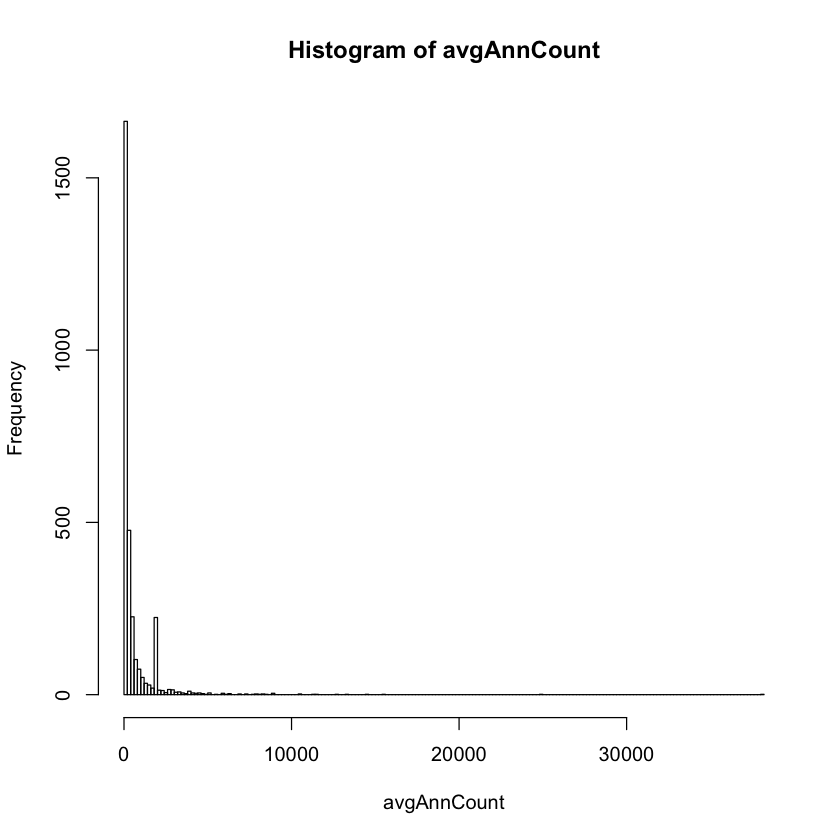

In [615]:
hist(cancer$avgAnnCount, breaks=200, main="Histogram of avgAnnCount", xlab="avgAnnCount", ylab='Frequency')

In [616]:
paste(length(filter(cancer, avgAnnCount >= 1962 & avgAnnCount < 1963)[['Geography']]), "counties are found with identical value of avgAnnCount, 1962.668")

[1] "206 counties are found with identical value of avgAnnCount, 1962.668"

An unusual spike is observed in the range of (1800, 1900) within the long tail of the distribution. The data contributing the distribution is likely to be erronous for the following reasons; (1) there is an identical value of avgAnnCount for a set of counties and (2) For some counties the avgAnnCount is higher than popEst2015 which cannot be plusible.

There are two potential approaches to fix the data; (1) Remove the erroneous data from analysis and (2) Replace the erroneous data with an average of non-erroneous data. Applicability of the approach depends on the application of the data. For example, if a regression parameters are derived from data points and data points values are estimated based on the regression parameters (e.g. content-based recommendation algorithm), it is preferrable to replace missing/erronous values with the average value of the non-erroneous data. Since in this analysis, we focus on understanding the statistical properties of various data fields, the erroneous data is removed.

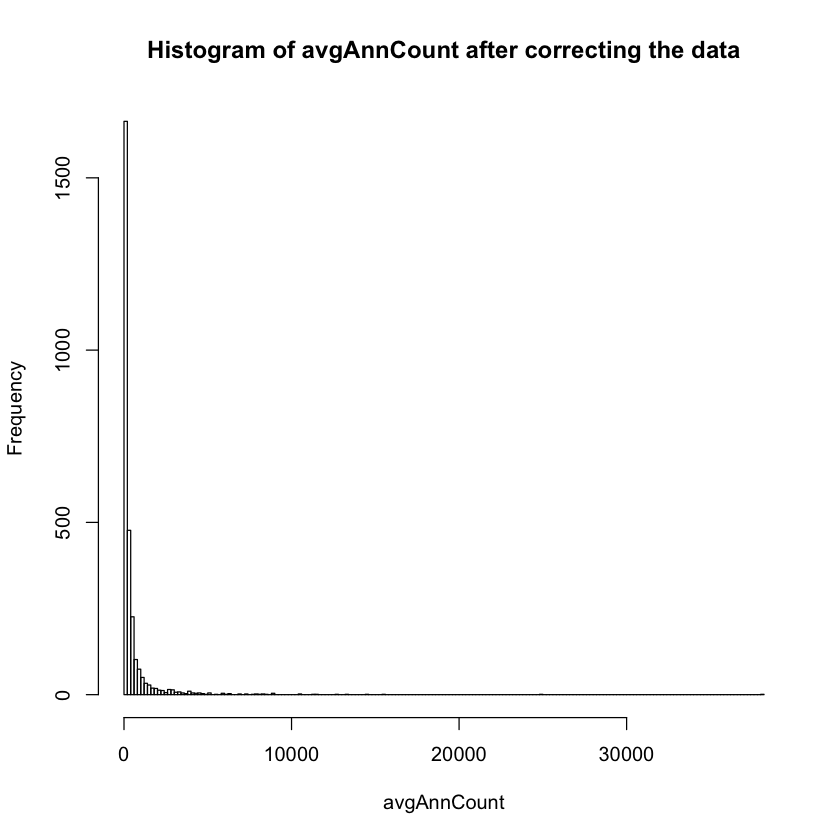

In [617]:
# Cleaning data by removing  identical value of avgAnnCount and higher value than popEst2015 before the bivariate analysis.
# TODO: The following apporach is very crude, and it can be replaced by a sophisticated code.
cancer$avgAnnCount <- replace(cancer$avgAnnCount, cancer$avgAnnCount > 1962 & cancer$avgAnnCount < 1963, NA)
cancer$avgAnnCount <- replace(cancer$avgAnnCount, cancer$avgAnnCount > cancer$popEst2015, NA)
hist(cancer$avgAnnCount, breaks=200, main="Histogram of avgAnnCount after correcting the data", xlab="avgAnnCount", ylab='Frequency')

The distribution of avgAnnCount is skewed. Many well-established statistical studies/models assumed a normal distribution of data, and thus, to conveniently apply these methods, we need to handle the skewness of the distribution. To handle left skewness, we can consider higher power tranformation like square or cube of the data. On the other hand, to handle right skewness, we can consider logerithmic or square root transformation.

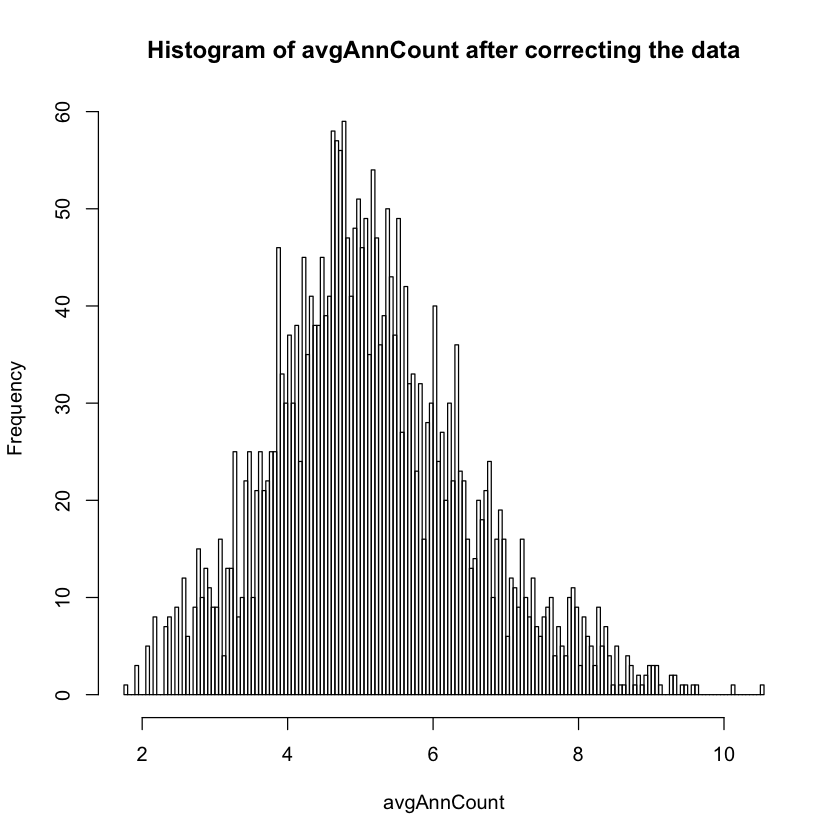

In [618]:
avgAnnCount_trans <- log(cancer$avgAnnCount)
hist(avgAnnCount_trans, breaks=200, main="Histogram of avgAnnCount after correcting the data", xlab="avgAnnCount", ylab='Frequency')
cancer$avgAnnCount <- avgAnnCount_trans

### Analyzing the MedianAge feature

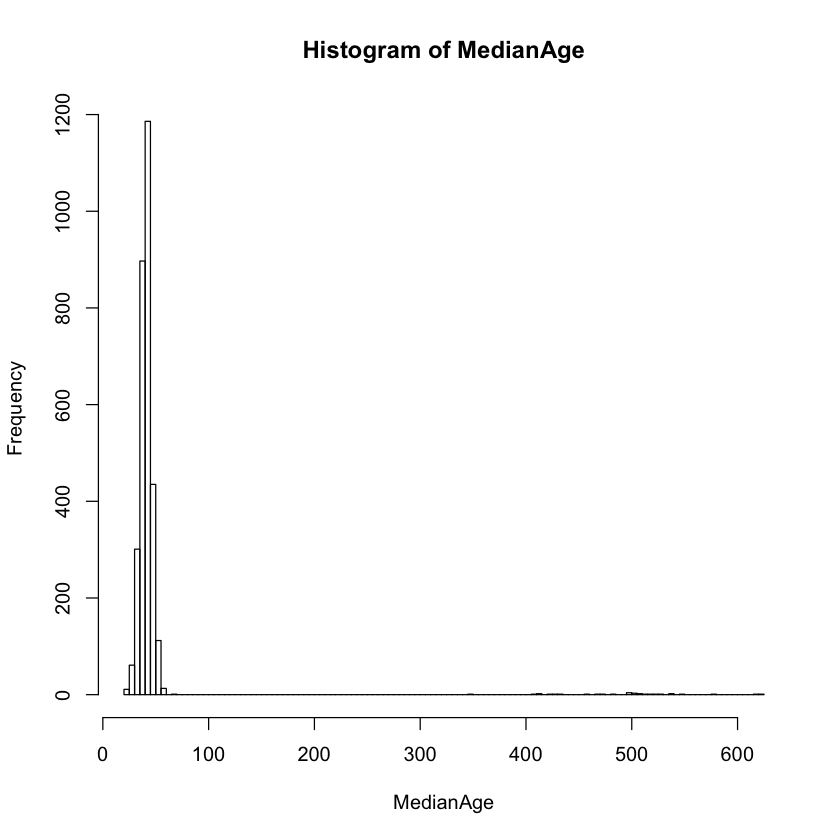

In [619]:
hist(cancer$MedianAge, breaks=100, main="Histogram of MedianAge", xlab="MedianAge", ylab='Frequency')

In [620]:
paste(length(filter(cancer, MedianAge > 125)[['Geography']]), "counties have median age higher than 125.")

[1] "30 counties have median age higher than 125."

The distribution of MedianAge is skewed due to some erronous records of MedianAge from 30 counties.


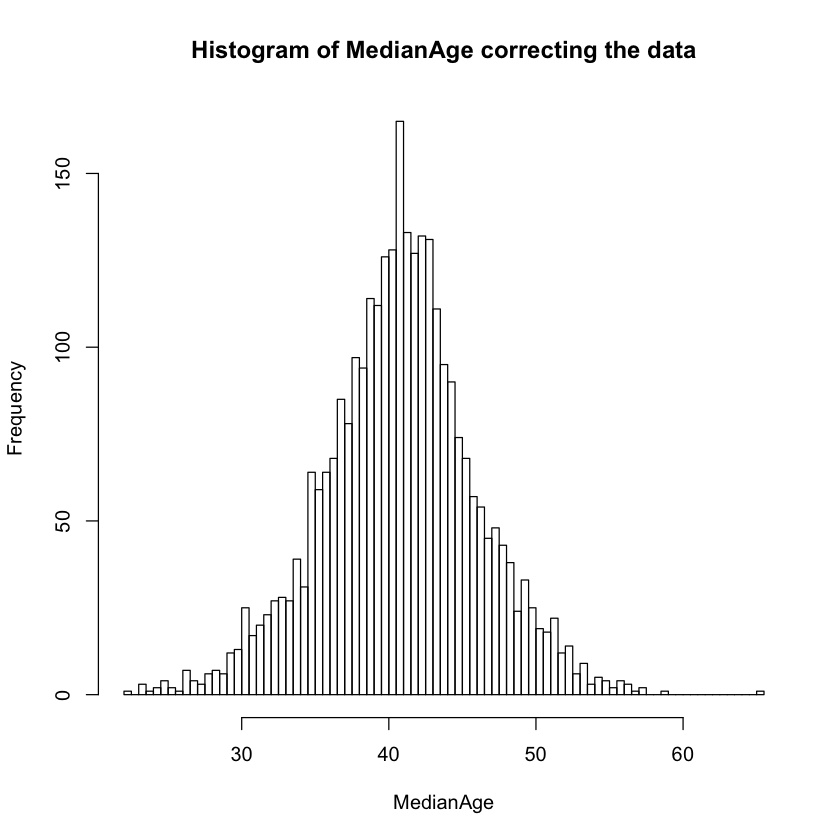

In [621]:
# Cleaning data by removing values higher than 125 that is the maximum reported age to this date.
# TODO: The following apporach is very crude, and it can be replaced by a sophisticated code.
cancer$MedianAge <- replace(cancer$MedianAge, cancer$MedianAge > 125, NA)
hist(cancer$MedianAge, breaks=100, main="Histogram of MedianAge correcting the data", xlab="MedianAge", ylab='Frequency')

### Analyzing the AvgHouseholdSize feature

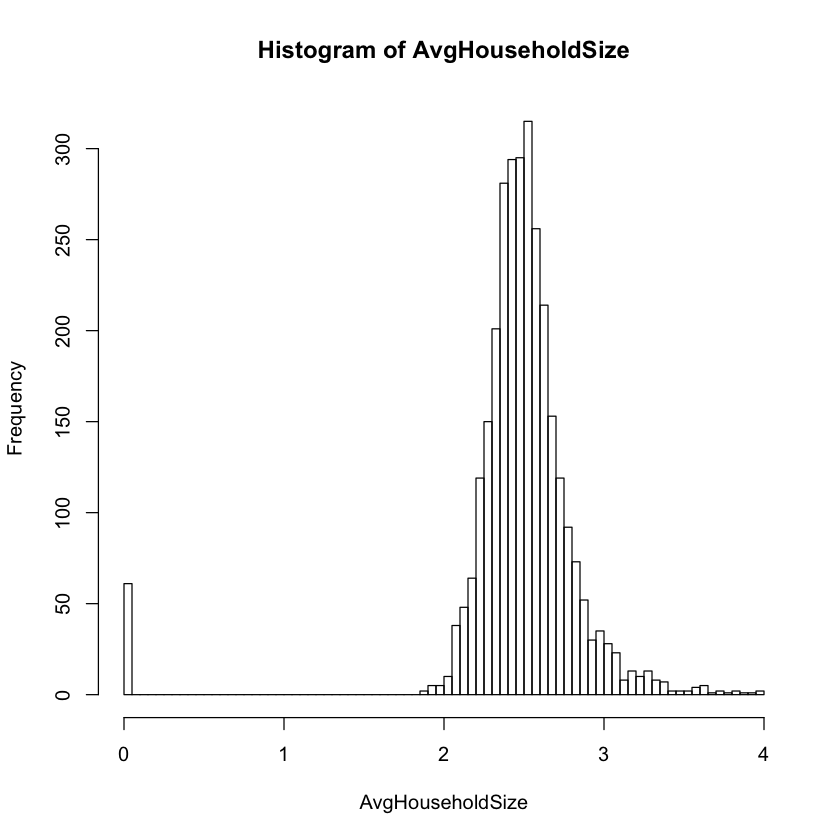

In [622]:
hist(cancer$AvgHouseholdSize, breaks=100, main="Histogram of AvgHouseholdSize", xlab="AvgHouseholdSize", ylab='Frequency')

In [623]:
paste("Number of houses with average size smaller than 2 are: ", length(filter(cancer, AvgHouseholdSize < 2)[['AvgHouseholdSize']]))
paste("Number of houses with average size greater than 3 are: ", length(filter(cancer, AvgHouseholdSize > 3)[['AvgHouseholdSize']]))

[1] "Number of houses with average size smaller than 2 are:  72"

[1] "Number of houses with average size greater than 3 are:  135"

There is no data issue observed in the distribution of the average house size (AvgHouseholdSize). The data contains ourliers both at the lower and higher ends of the distributins. The number of houses with average size smaller than 0.03 and greater than 3.8 are 59 and 6 respectively. These outliers contributes to skewness in the distribution.

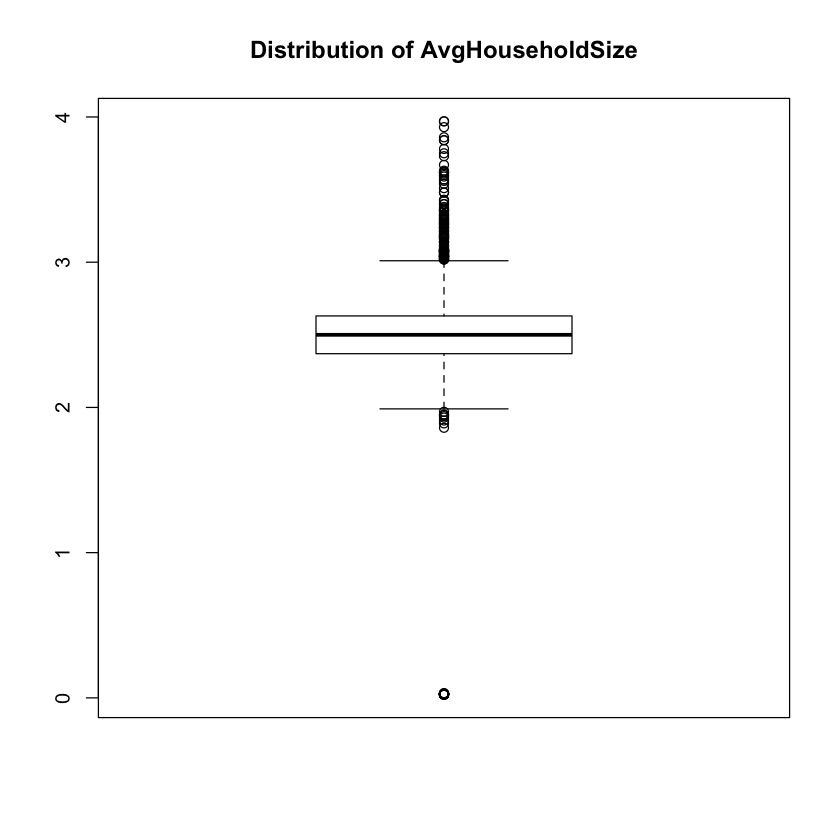

In [624]:
boxplot(cancer$AvgHouseholdSize, main="Distribution of AvgHouseholdSize")

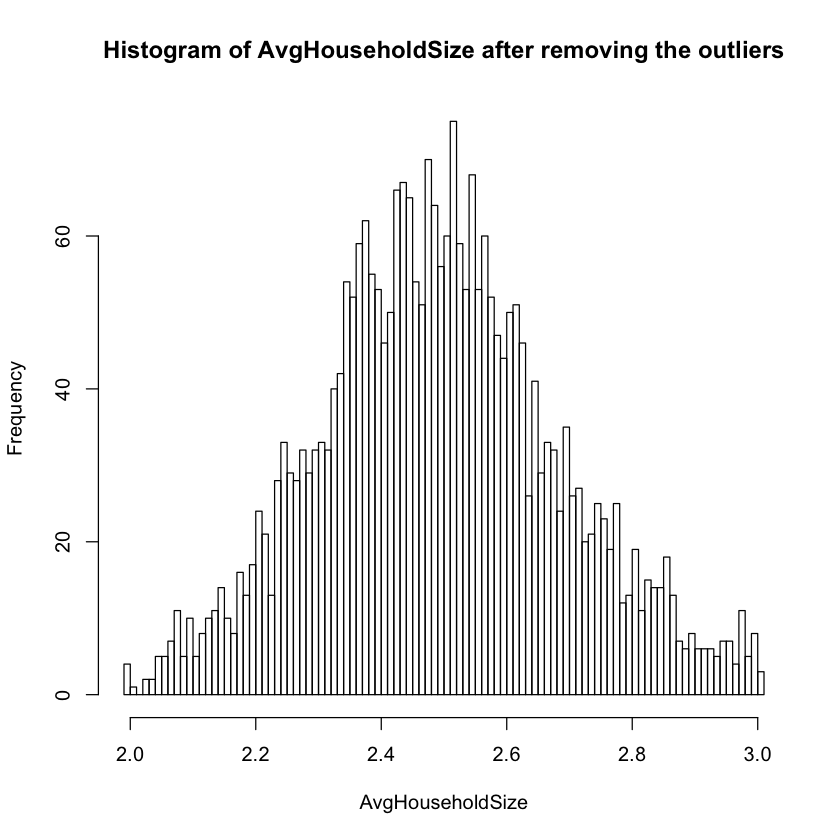

In [625]:
outlier_values <- boxplot.stats(cancer$AvgHouseholdSize)$out
cancer$AvgHouseholdSize <- replace(cancer$AvgHouseholdSize, cancer$AvgHouseholdSize %in% outlier_values, NA)
hist(cancer$AvgHouseholdSize, breaks=100, main="Histogram of AvgHouseholdSize after removing the outliers", xlab="AvgHouseholdSize", ylab='Frequency')

### Analyzing the PctAsian feature

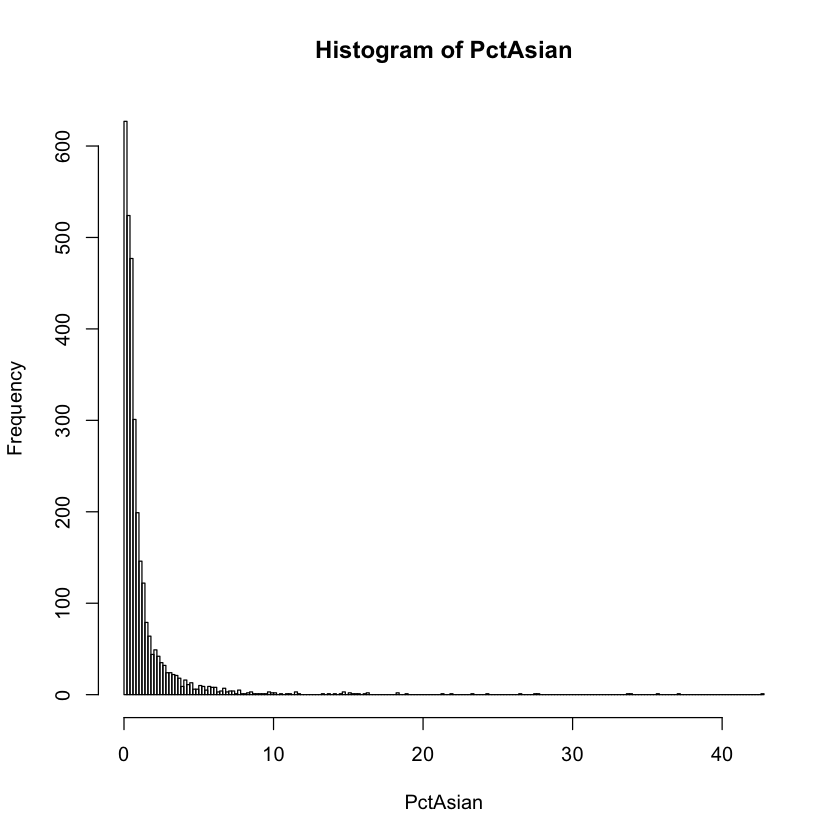

In [626]:
hist(cancer$PctAsian, breaks=200, main="Histogram of PctAsian", xlab="PctAsian", ylab='Frequency')

There is no data issue found for the percentage of Asian (PctAsian). The heave tail represents high concentration of Asians in some of the counties. So, we applying log transformation to the distribution ignore the impact of outliers.

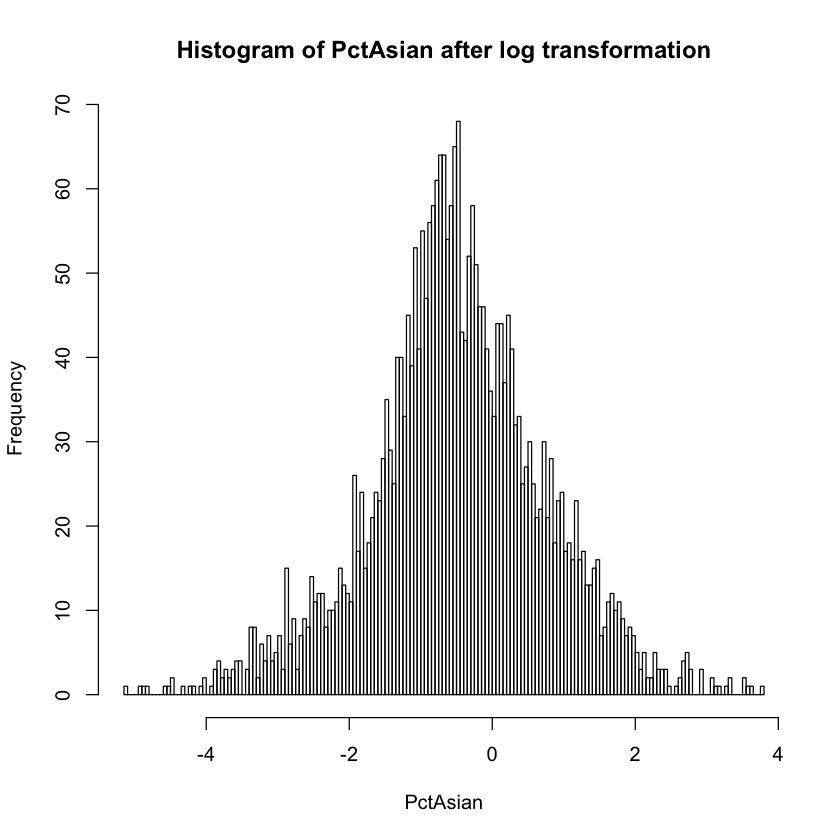

In [627]:
PctAsian_trans <- log(cancer$PctAsian)
hist(PctAsian_trans, breaks=200, main="Histogram of PctAsian after log transformation", xlab="PctAsian", ylab='Frequency')
cancer$PctAsian <- PctAsian_trans

In [628]:
### Analyzing the PctOtherRace feature

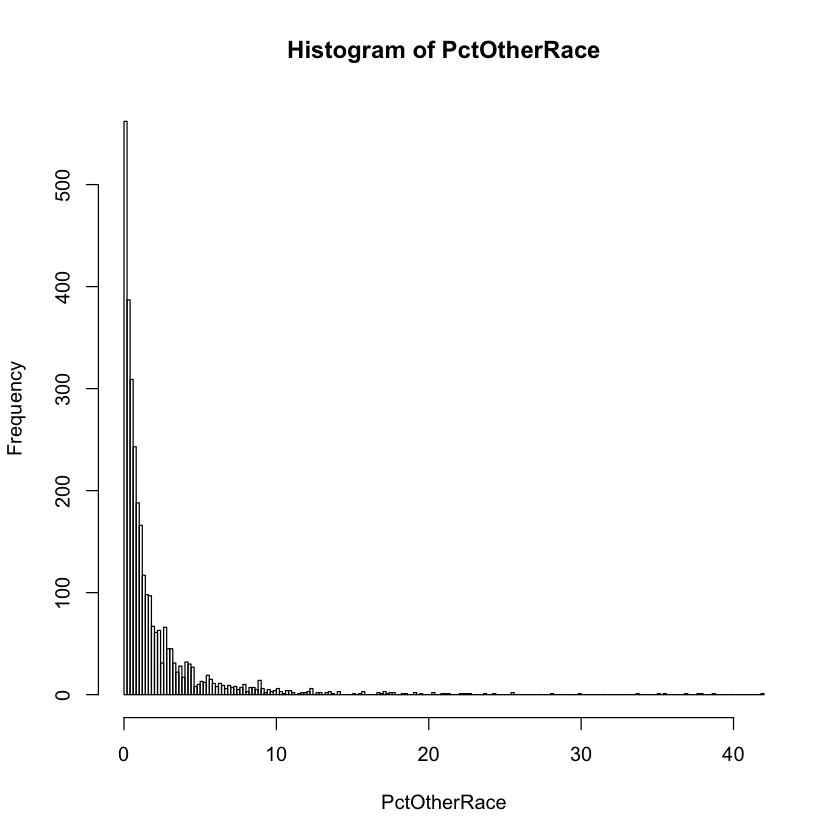

In [629]:
hist(cancer$PctOtherRace, breaks=200, main="Histogram of PctOtherRace", xlab="PctOtherRace", ylab='Frequency')

There is no data issue found for the percentage of Asian (PctAsian). The heave tail represents high concentration of other races in some of the counties. So, we applying log transformation to the distribution ignore the impact of outliers.

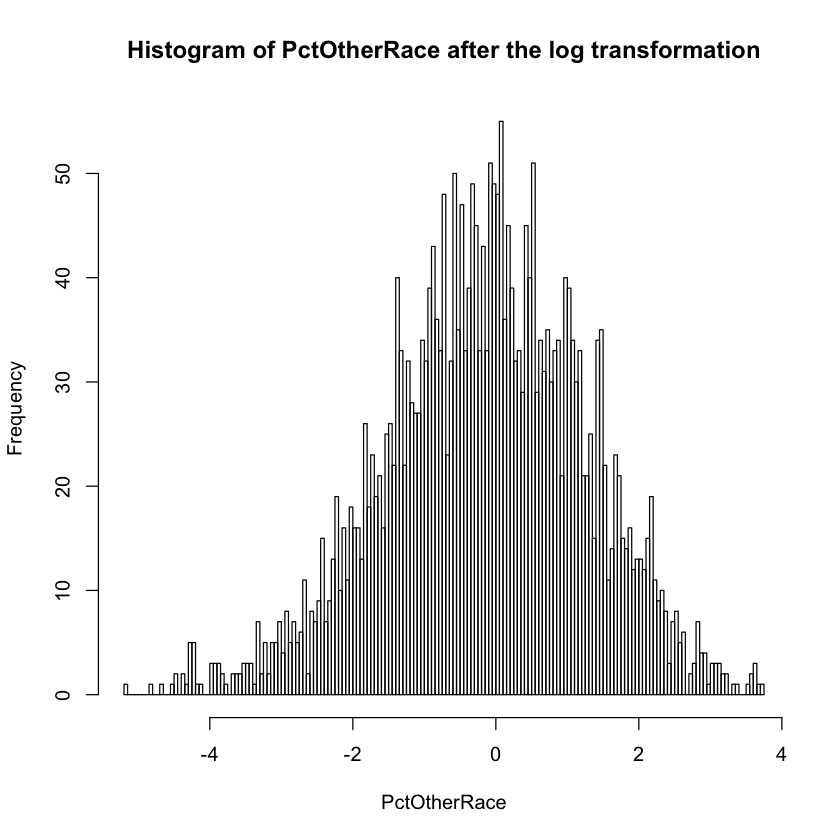

In [630]:
PctOtherRace_trans <- log(cancer$PctOtherRace)
hist(PctOtherRace_trans, breaks=200, main="Histogram of PctOtherRace after the log transformation", xlab="PctOtherRace", ylab='Frequency')
cancer$PctOtherRace <- PctOtherRace_trans

### Analyzing the PctBachDeg18_24 feature

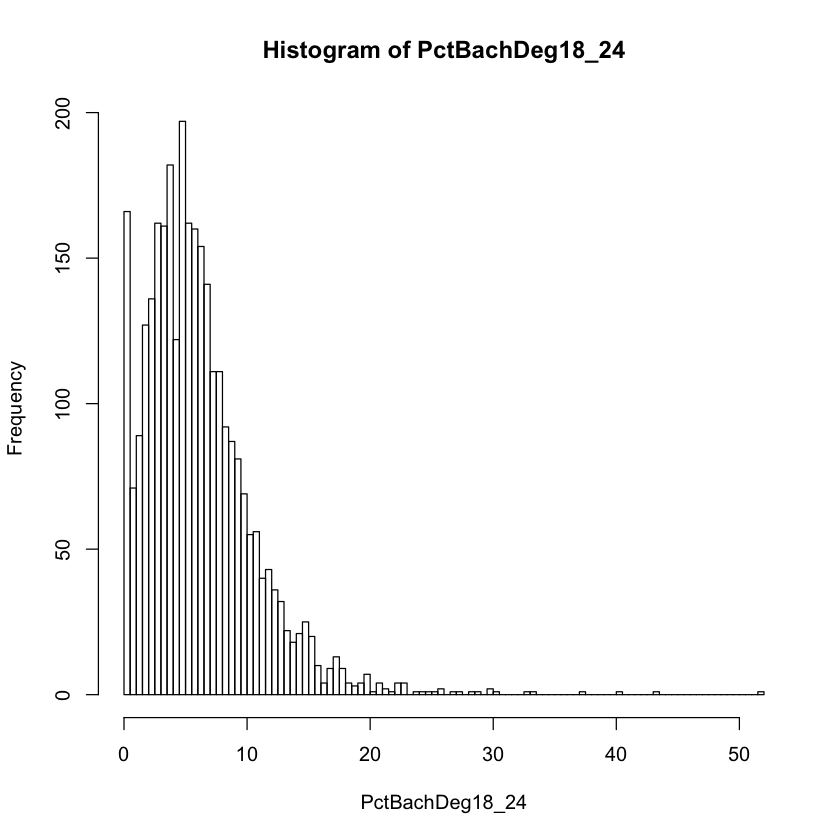

In [631]:
hist(cancer$PctBachDeg18_24, breaks=100, main="Histogram of PctBachDeg18_24", xlab="PctBachDeg18_24", ylab='Frequency')

In [632]:
paste("The range of the population with Bachelor degee is ", paste(range(cancer$PctBachDeg18_24), collapse=" ~ "))

[1] "The range of the population with Bachelor degee is  0 ~ 51.8"

Since the range of the population with Bachelor degee is in a valid range, the outliers are contributing in the heavy right skewness. For this data, the log transformation transforms the distribution left-skewed from right-skewed. That indicates the presense of outliers is responsible for the skewness, and thus, we removed the outliers.

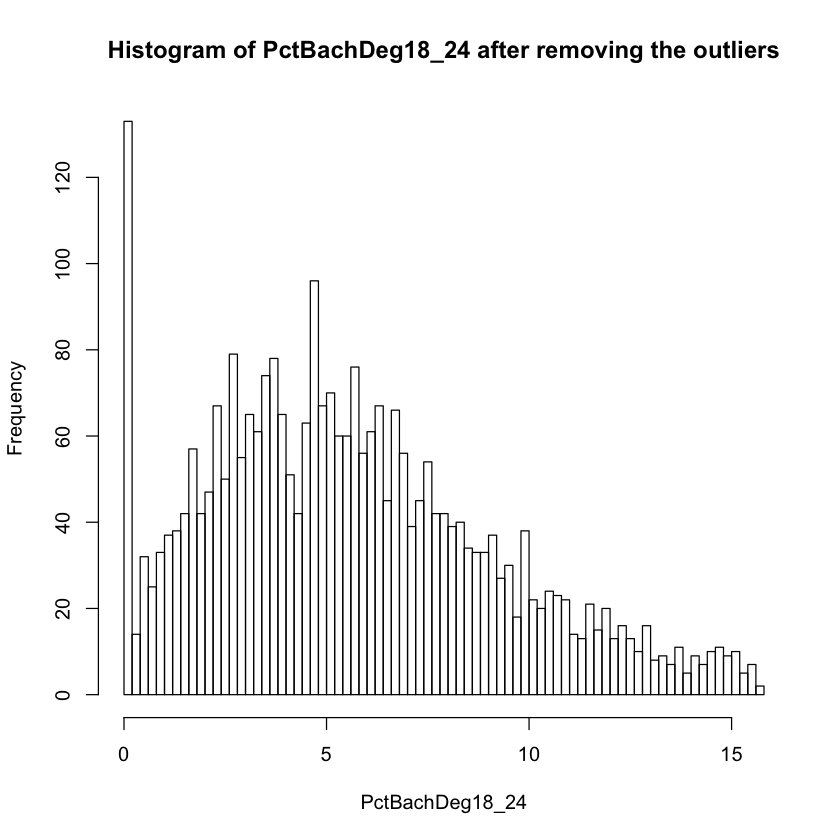

In [633]:
#PctBachDeg18_24_trans <- log(cancer$PctBachDeg18_24)
#hist(PctBachDeg18_24_trans, breaks=200, main="Histogram of PctBachDeg18_24 after the log transformation", xlab="PctBachDeg18_24", ylab='Frequency')
#cancer$PctBachDeg18_24 <- PctBachDeg18_24_trans

outlier_values <- boxplot.stats(cancer$PctBachDeg18_24)$out
cancer$PctBachDeg18_24 <- replace(cancer$PctBachDeg18_24, cancer$PctBachDeg18_24 %in% outlier_values, NA)
hist(cancer$PctBachDeg18_24, breaks=100, main="Histogram of PctBachDeg18_24 after removing the outliers", xlab="PctBachDeg18_24", ylab='Frequency')

### Analyzing the PctBachDeg25_Over feature

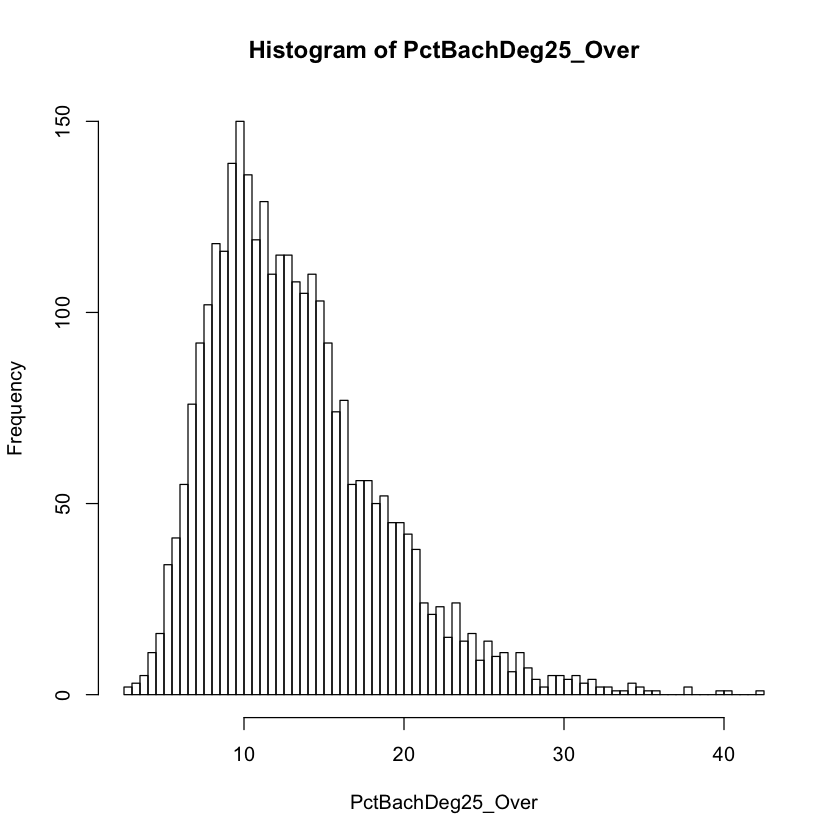

In [634]:
hist(cancer$PctBachDeg25_Over, breaks=100, main="Histogram of PctBachDeg25_Over", xlab="PctBachDeg25_Over", ylab='Frequency')

The distribution of the percentage of bachelor over 25 years is right skewed. For this data, the log transformation transforms the distribution left-skewed from right-skewed. That indicates the presense of outliers is responsible for the skewness, and thus, we removed the outliers.

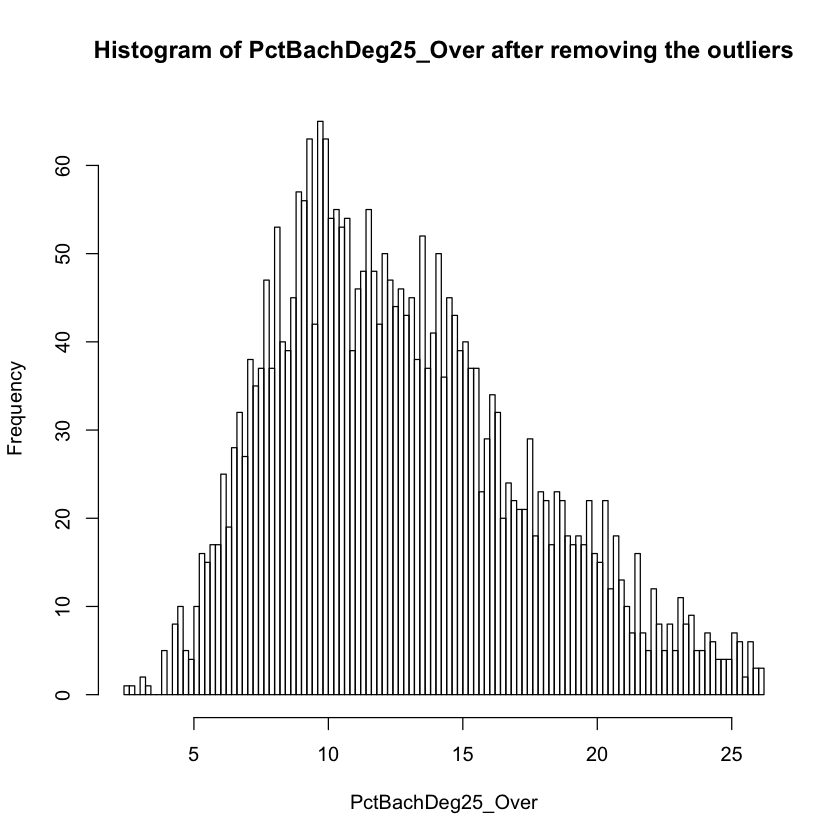

In [635]:
#PctBachDeg25_Over_trans <- log(cancer$PctBachDeg25_Over)
#hist(PctBachDeg25_Over_trans, breaks=100, main="Histogram of PctBachDeg25_Over after the log transformation", xlab="PctBachDeg25_Over", ylab='Frequency')
#cancer$PctBachDeg25_Over <- PctBachDeg25_Over_trans

outlier_values <- boxplot.stats(cancer$PctBachDeg25_Over)$out
cancer$PctBachDeg25_Over <- replace(cancer$PctBachDeg25_Over, cancer$PctBachDeg25_Over %in% outlier_values, NA)
hist(cancer$PctBachDeg25_Over, breaks=100, main="Histogram of PctBachDeg25_Over after removing the outliers", xlab="PctBachDeg25_Over", ylab='Frequency')

### Analyzing the PctWhite feature

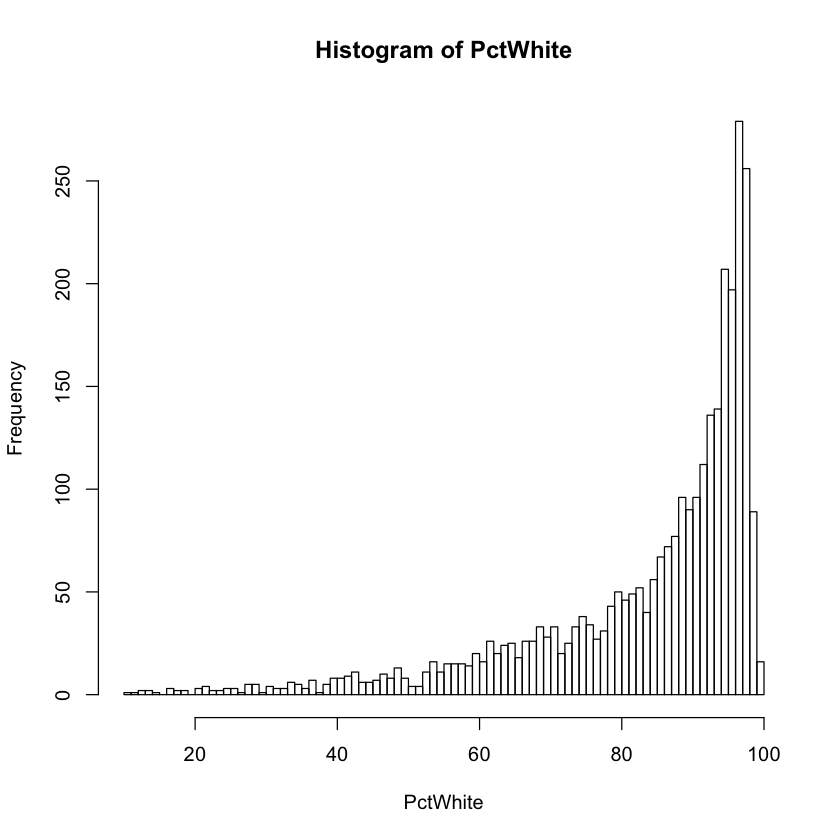

In [636]:
hist(cancer$PctWhite, breaks=100, main="Histogram of PctWhite", xlab="PctWhite", ylab='Frequency')

The distribution of the percentage of white is left skewed, and thus, applying square transformation.

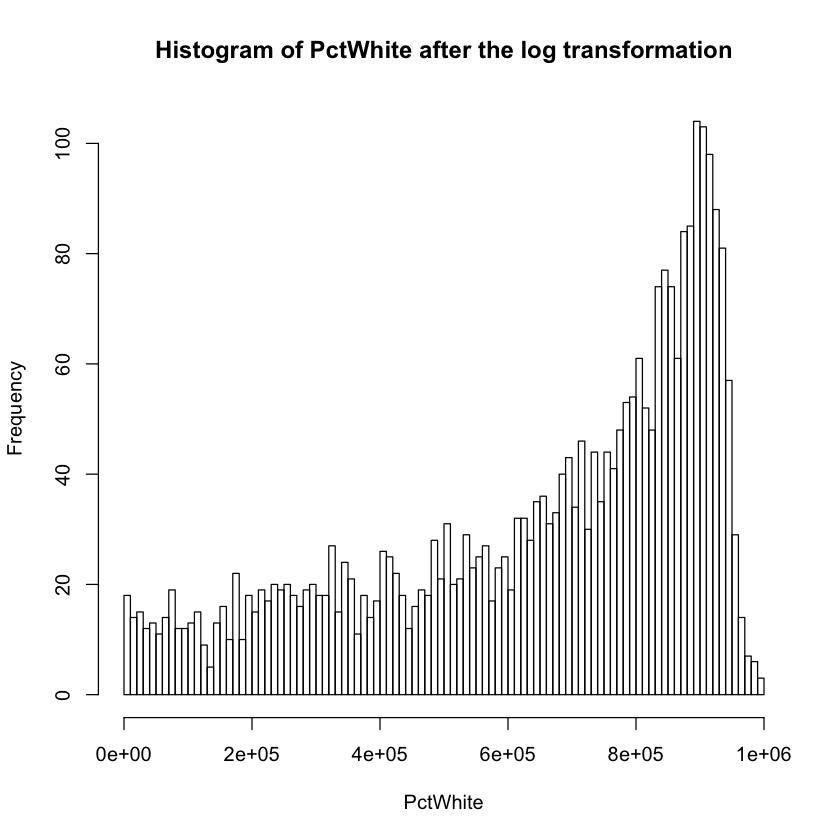

In [637]:
PctWhite_trans <- (cancer$PctWhite * cancer$PctWhite * cancer$PctWhite)
hist(PctWhite_trans, breaks=100, main="Histogram of PctWhite after the log transformation", xlab="PctWhite", ylab='Frequency')
cancer$PctWhite <- PctWhite_trans

### Analyzing the PctBlack feature

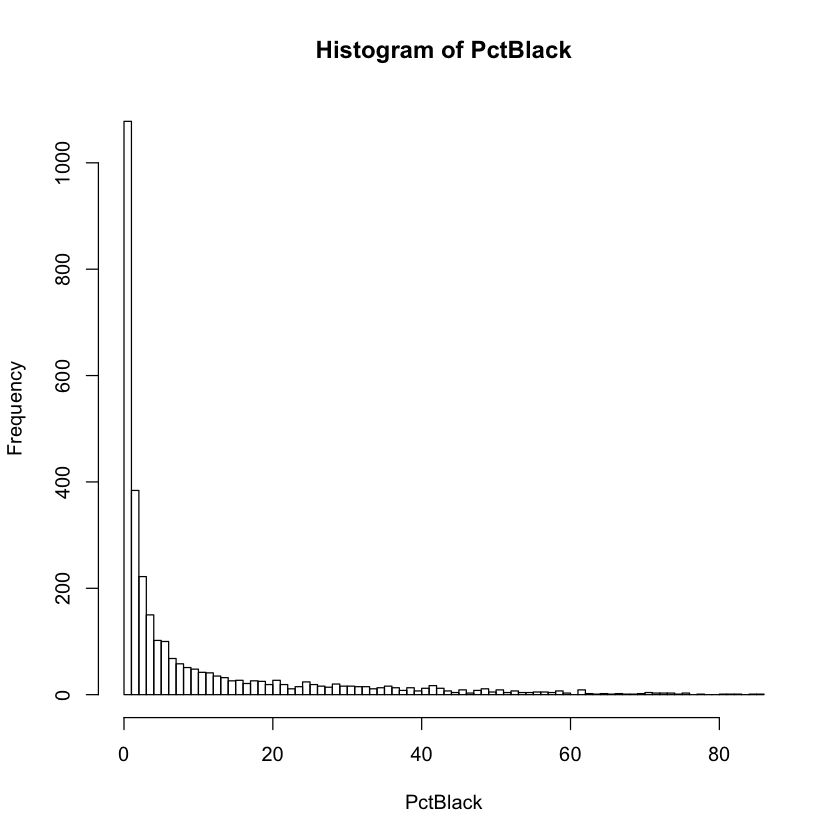

In [638]:
hist(cancer$PctBlack, breaks=100, main="Histogram of PctBlack", xlab="PctBlack", ylab='Frequency')

The distribution of the percentage black is right skewed, and thus, applying a log transformation.

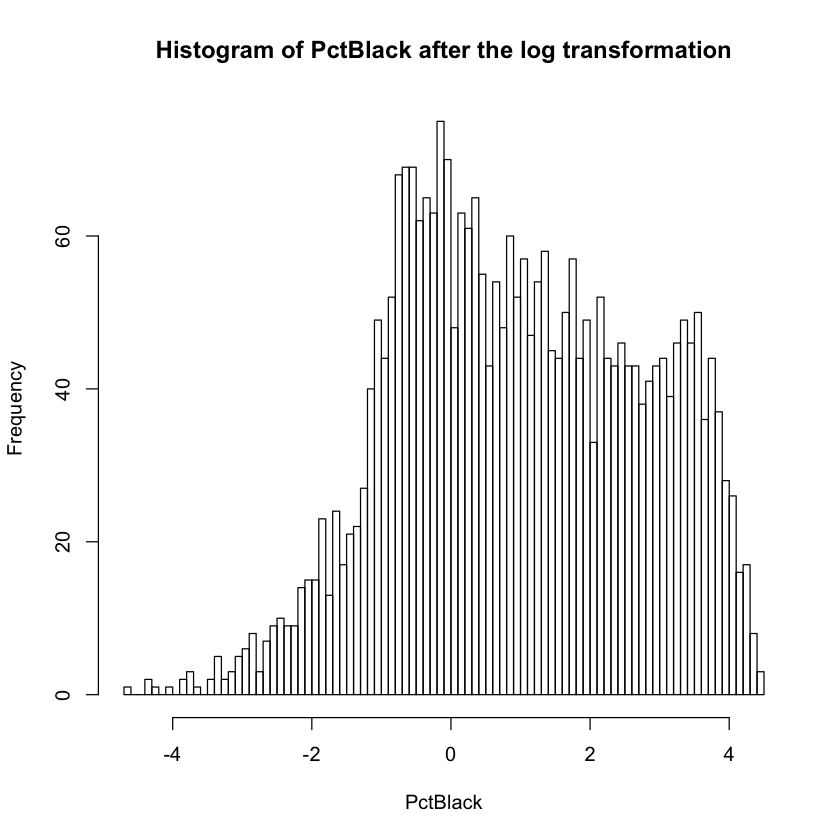

In [639]:
PctBlack_trans <- log(cancer$PctBlack)
hist(PctBlack_trans, breaks=100, main="Histogram of PctBlack after the log transformation", xlab="PctBlack", ylab='Frequency')
cancer$PctBlack <- PctBlack_trans

### Analyzing the BirthRate feature

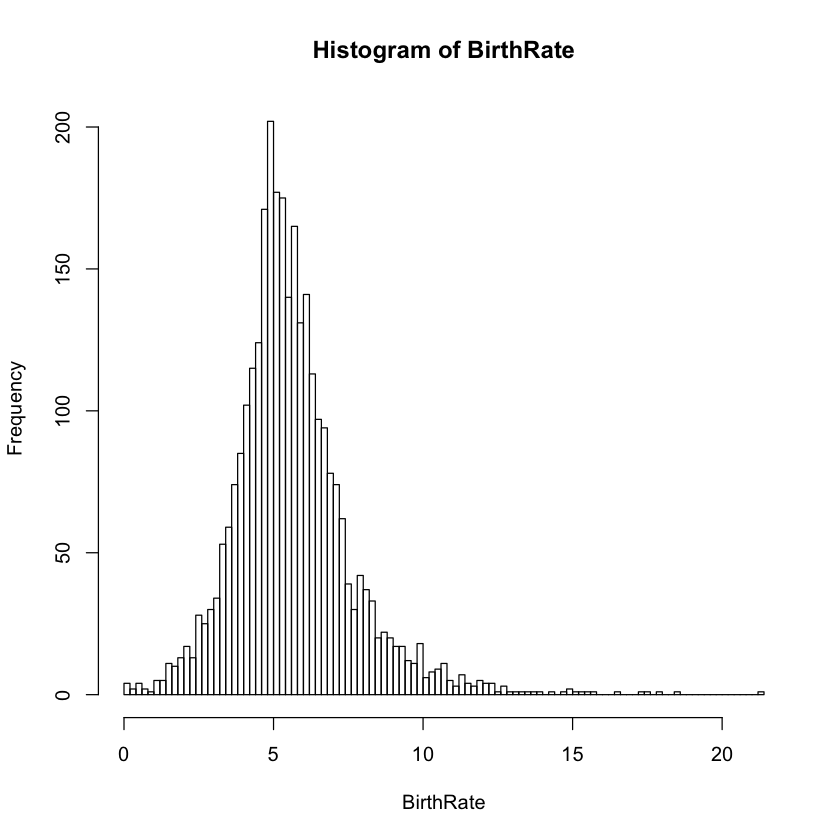

In [640]:
hist(cancer$BirthRate, breaks=100, main="Histogram of BirthRate", xlab="BirthRate", ylab='Frequency')

The distribution of birth rate is right skewed, and thus, applying a log transformation.

[1] "The range of birth rate is  0 ~ 21.32616487"

[1] "Number of counties with birth rate smaller than 0 are:  0"

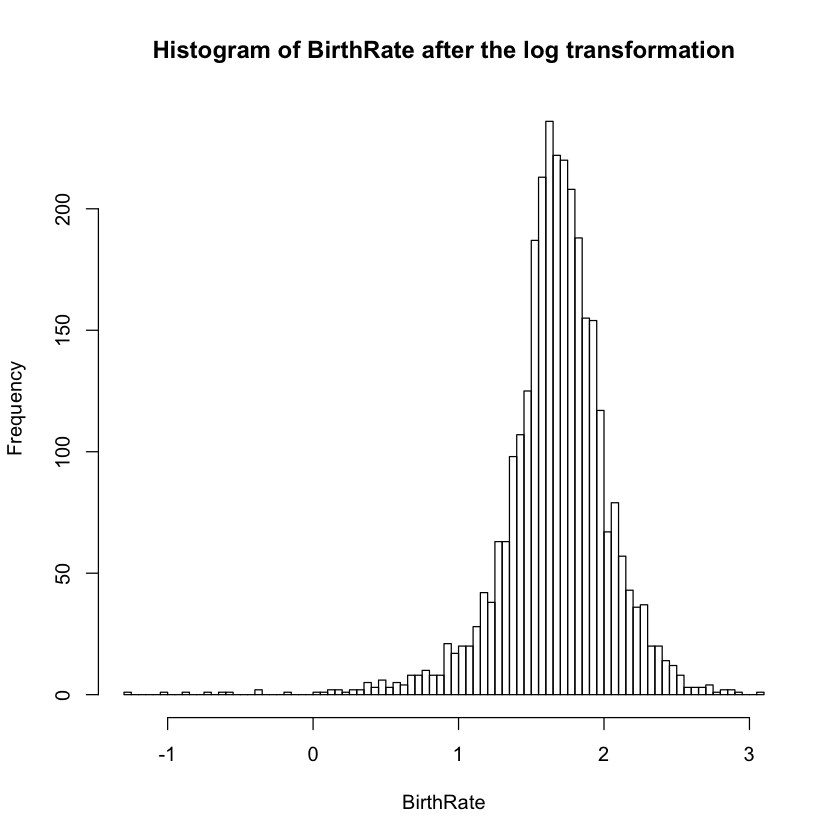

In [641]:
paste("The range of birth rate is ", paste(range(cancer$BirthRate), collapse=" ~ "))
paste("Number of counties with birth rate smaller than 0 are: ", length(filter(cancer, BirthRate < 0)[['AvgHouseholdSize']]))
#cancer$BirthRate <- replace(cancer$BirthRate, cancer$BirthRate < 0, NA)
BirthRate_trans <- log(cancer$BirthRate)
hist(BirthRate_trans, breaks=100, main="Histogram of BirthRate after the log transformation", xlab="BirthRate", ylab='Frequency')
cancer$BirthRate <- BirthRate_trans